# Ajuste y Validacion de un modelo supervisado

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos LIMITADOS a 20,000 registros
df = pd.read_csv('/content/IMDB TMDB Movie Metadata Big Dataset (1M).csv', nrows=20000)

# Alternativamente, si ya cargaste el archivo completo:
# df = pd.read_csv('/content/movies_data/movies_metadata.csv')
# df = df.head(20000)  # Primeras 20,000 filas

# O para muestra aleatoria:
# df = df.sample(n=20000, random_state=42)  # 20,000 filas aleatorias

print(f"Dataset cargado: {len(df)} registros")

# Preprocesamiento
df_clean = df.dropna(subset=['vote_average', 'popularity', 'budget', 'revenue'])
df_clean['rating_category'] = pd.cut(df_clean['vote_average'],
                                       bins=[0, 5, 7, 10],
                                       labels=['Baja', 'Media', 'Alta'])

# Features y target
X = df_clean[['popularity', 'budget', 'revenue', 'runtime']].fillna(0)
y = df_clean['rating_category'].dropna()

# Alinear X e y
X = X.loc[y.index]

print(f"Registros después de limpieza: {len(X)}")

# Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Dataset cargado: 20000 registros
Registros después de limpieza: 20000


# Grid Search y Optimización de Hiperparámetros

In [3]:
# Grid de parámetros REDUCIDO (mucho más rápido)
param_grid = {
    'C': [0.1, 1, 10],              # Reducido de 4 a 3 valores
    'gamma': ['scale', 0.01],       # Reducido de 5 a 2 valores
    'kernel': ['linear', 'rbf']     # Eliminado 'poly' (muy lento)
}

# Usar MENOS folds en cross-validation
grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    cv=3,                # Cambio de 5 a 3 folds
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Iniciando Grid Search optimizado...")
grid_search.fit(X_train, y_train)


Iniciando Grid Search optimizado...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 0.01],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

# Validación y Evaluación del Modelo


=== RESULTADOS DEL MODELO ===
Accuracy en test: 0.6875

Reporte de clasificación:
              precision    recall  f1-score   support

        Alta       0.61      0.19      0.29      1146
        Baja       0.00      0.00      0.00       187
       Media       0.69      0.95      0.80      2667

    accuracy                           0.69      4000
   macro avg       0.44      0.38      0.37      4000
weighted avg       0.64      0.69      0.62      4000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-validation (10-fold):
Media: 0.6795 (+/- 0.0376)


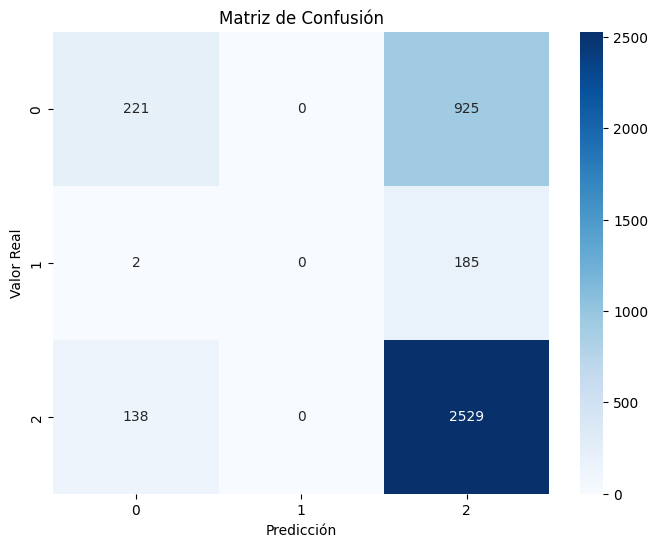

In [4]:
# Modelo con mejores parámetros
best_svm = grid_search.best_estimator_

# Predicciones
y_pred = best_svm.predict(X_test)

# Métricas de rendimiento
print("\n=== RESULTADOS DEL MODELO ===")
print(f"Accuracy en test: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Cross-validation adicional (10-fold)
cv_scores = cross_val_score(best_svm, X_scaled, y, cv=10, scoring='accuracy')
print(f"\nCross-validation (10-fold):")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# Documentación de Resultados

In [5]:
# Crear DataFrame con resultados de Grid Search
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("\nTop 5 combinaciones de parámetros:")
print(results_df[['params', 'mean_test_score', 'std_test_score']].head())

# Guardar resultados
results_df.to_csv('svm_grid_search_results.csv', index=False)
print("\nResultados guardados en 'svm_grid_search_results.csv'")



Top 5 combinaciones de parámetros:
                                           params  mean_test_score  \
9    {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.690375   
5     {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.687875   
1   {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}         0.682125   
11      {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}         0.677625   
7        {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}         0.673687   

    std_test_score  
9         0.005680  
5         0.003241  
1         0.001566  
11        0.000705  
7         0.001171  

Resultados guardados en 'svm_grid_search_results.csv'
